# IMAGINE model library demo

In this short demo, we illustrate the interface of the model library. 
We will discuss 


In [1]:
import ImagineModels as img
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

### 1.) Model initialization and evaluation at position

All models are implemented as classes with a similar interface. 
The simplest way to initialize such class (in this case the [Jaffe et al.](https://arxiv.org/abs/0907.3994) model) is via

In [2]:
jf12 = img.JF12RegularField()

All models assume a Galacto-centric coordinate system in units of kiloparsec.
They can be evaluated at a position via the `at_position` member function:

In [3]:
position = [2, -2, 0.1]
bfield_at_position = jf12.at_position(*position)
print(bfield_at_position)

[0.32188229898803716, -0.13192063657348066, -1.7165051848966735]


### 2.) Evaluation on grid

Alternatively, one may evaluate the model on a regular grid via the `on_grid` member function.
For this, one needs to specify the number of cells, the cell increment and the zeropoint (i.e. the location of the point with minimal coordinate in all directions, again in Galacto-centric coordinates). 
The output will  

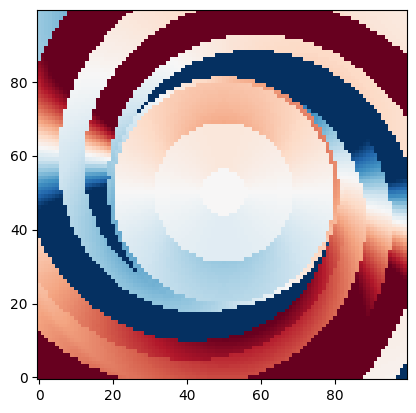

In [4]:
grid_shape = [100, 100, 1] # necessarily a list of 3 ints! 
increment = [.16, .16, .001]  
zeropoint = [-8, -8, 0]

bfield_on_regular_grid = jf12.on_regular_grid(grid_shape, increment, zeropoint)

plt.imshow(bfield_on_regular_grid[1][:, :, 0], cmap='RdBu_r', origin='lower', vmin=-0.6, vmax=0.6)

A third possibility to evaluate the model is on an irregular grid. 
For this, one needs to specify the x, y and z coordinates in separate arrays: 

In [5]:
x_coordinates = [-10, -9.5, 2]
y_coordinates = [-5, -2, 0, .4]
z_coordinates = [-.1, 0, .1]

bfield_on_irregular_grid = jf12.on_grid(x_coordinates, y_coordinates, z_coordinates)

### 3.) Model parameters 

The model parameters are implemented as attributes of the classes:

In [6]:
print(jf12.b_arm_1 )

0.1


One can simply update the model parameters via  

In [7]:
jf12.b_arm_1  = 3.14
print(jf12.b_arm_1)

3.14


## 4.) Alternative initialization

It is also possible to initialize the models directly with the grid parameters, either regular or irregular: 

In [8]:
jaffe_regular = img.JaffeMagneticField(grid_shape, increment, zeropoint)
jaffe_irregular = img.JaffeMagneticField(x_coordinates, y_coordinates, z_coordinates)

The grid can then be evaluated via 

In [9]:
bfield_on_regular_grid = jaffe_regular.on_grid()

Other grids can still be passed directly to `on_grid`. 

In the case of the Jaffe model, there is no immediate advantage of passing the grid to the member function or initializing the model with it, apart from maybe more structured code in the latter case. 

For some models, however, initializing the model with the grid maybe advantageous, as some components may be precomputed, resulting in a potentially significant speed advantage.   

In [10]:
grid_shape = [100, 100, 2] # necessarily a list of 3 ints! 
increment = [.16, .16, .1]  
zeropoint = [-8, -8, 0.]
jf12_random_1 = img.JF12RandomField() # intialize without grid
jf12_random_1.on_grid(grid_shape, increment, zeropoint, 23)

# plt.imshow(bfield_on_regular_grid[1][:, :, 0], cmap='RdBu_r', origin='lower', vmin=-0.6, vmax=0.6)

[array([[[ 7.65699674e+04,  1.22906312e+05,  1.16344924e+05, ...,
           2.02764148e+05,  1.87991597e+05,  1.28119587e+05],
         [-1.36121786e+02, -2.53480012e+01,  2.68237861e+05, ...,
           1.59437967e+05,  1.63093272e+05,  1.96089014e+05],
         [ 2.03782807e+05,  2.12445536e+05, -2.43663476e+03, ...,
           1.32879895e+05,  1.40497933e+05,  1.45343348e+05],
         ...,
         [ 1.44356700e+05,  1.27908566e+05,  1.12092369e+05, ...,
           1.04919059e+05,  1.01070647e+05,  1.01863942e+05],
         [ 9.34870474e+04,  9.23999728e+04,  9.73600164e+04, ...,
           1.22358007e+05,  1.34576463e+05,  1.13335879e+05],
         [ 8.75570236e+04,  8.08322453e+04,  5.21720858e+04, ...,
           1.38931993e+05,  1.40757382e+05,  1.31081108e+05]],
 
        [[ 9.53042368e+04,  9.71660409e+04,  1.05776403e+05, ...,
           1.58212800e+05,  1.40334851e+05,  1.53388215e+05],
         [ 1.46921347e+05,  1.13352445e+05,  1.12366403e+05, ...,
           1.16909126

### 5.) Random models

Random models (i.e. models which have many degrees of freedom which are not directly accessible, but are drawn from some probability distribution) have the same interface as regular models with some restrictions: 

1. Irregular grids are not supported, due to the fact that the models make use of Fast Fourier Transforms (FFTs).
2. Evaluation at a single position is (not yet) supported.

This only leaves the possibility to evaluate these models on a regular grid. Since random models rely on the FFTW3 module, 
initializing the models with the grid may result in somewhat faster evaluation, as this allows the precomputation of fftw `wisdom'. 
Of course this implies longer initialization.

In [11]:
import time
random_seed = 23

grid_shape = [20, 30, 40] # again necessarily a list of 3 ints! 
increment = [.2, .3, .01]  
zeropoint = [-10, -5, -.2]

start = time.time()
jf12_random_1 = img.JF12RandomField() # intialize without grid
end = time.time()
print('Case 1: Init without grid: ',  end - start)

start = time.time()
jf12_random_1.on_grid(grid_shape, increment, zeropoint, random_seed)
end = time.time()
print('Case 1: Filled grid in: ',  end - start)

start = time.time()
jf12_random_2 = img.JF12RandomField(grid_shape, increment, zeropoint) # intialize with grid
end = time.time()
print('Case 2: Init with grid: ',  end - start)

start = time.time()
jf12_random_2.on_grid(random_seed)
end = time.time()
print('Case 2: Filled grid in: ',  end - start)


Case 1: Init without grid:  0.0001361370086669922
Case 1: Filled grid in:  0.011641502380371094
Case 2: Init with grid:  0.12502622604370117
Case 2: Filled grid in:  0.00830698013305664


This makes it evident, that the first case is preferable if the on_grid function is called only a few times, while the latter case will give a speed advantage with many calls (~30 in this specific example).